In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torch.cuda.amp import autocast, GradScaler
import time

if 'google.colab' in sys.modules:
    !pip install torchsummary
    !pip install albumentationsx
    !pip install torch_lr_finder
    # !pip install torch-lr-finder -v --global-option="apex"

import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from tqdm import tqdm

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True  # <-- important in Jupyter
)
logger = logging.getLogger(__name__)

from model_v1 import ResNet

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(f"Cuda available = {is_cuda}, Using device = {device}")

Cuda available = True, Using device = cuda


In [5]:
# Mean and Standard Deviation of CIFAR-100 dataset
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)
if 'google.colab' in sys.modules:
    BATCH_SIZE = 3072
else:
    BATCH_SIZE = 32
CIFAR100_LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
logger.info(f"Lenth of class names = {len(CIFAR100_LABELS)}")
GET_DATASET_STATS_FLAG = True

2025-10-17 01:29:33,501 - INFO - Lenth of class names = 100


In [6]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # CIFAR100 gives PIL image -> convert to numpy
        img = np.array(img)
        # Apply Albumentations
        augmented = self.transform(image=img)
        return augmented["image"]

# Denormalization function for viz/stats (add this helper)
def denormalize(tensor_img, mean=CIFAR100_MEAN, std=CIFAR100_STD):
    """Denormalize tensor for display (assumes C x H x W, values in [-2,2] approx)."""
    tensor_img = tensor_img.clone()  # Avoid modifying original
    for t, m, s in zip(tensor_img, mean, std):
        t.mul_(s).add_(m)  # Unnormalize
    return torch.clamp(tensor_img, 0, 1)  # Clamp to [0,1]

train_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=(-0.0625, 0.0625),
        scale_limit=(-0.1, 0.1),
        rotate_limit=(-15, 15),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        rotate_method="largest_box",
        p=0.5),
    A.CoarseDropout(
        num_holes_range=(1,1),
        hole_height_range=(10, 15),
        hole_width_range=(10, 15),
        fill=0,
        p=0.5
    ),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

test_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
cifar_train_dataset = datasets.CIFAR100(
    root='../../',
    train=True,
    download=True,
    transform=train_transforms,
)

cifar_test_dataset = datasets.CIFAR100(
    root='../../',
    train=False,
    download=True,
    transform=test_transforms,
)

train_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 0, 'pin_memory': is_cuda}
test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': False,  'num_workers': 0, 'pin_memory': is_cuda}

train_loader = torch.utils.data.DataLoader(cifar_train_dataset, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(cifar_test_dataset,  **test_kwargs)

100%|██████████| 169M/169M [00:14<00:00, 11.8MB/s]


2025-10-17 01:15:26,630 - INFO - Flatten images size (1025024,), (1025024,), (1025024,)


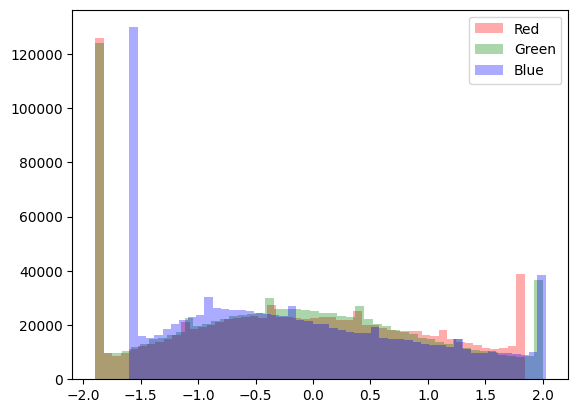

In [8]:
if GET_DATASET_STATS_FLAG:
    # Note: This computes stats on transformed (augmented + normalized) data, which isn't ideal for verifying raw mean/std.
    # If you want raw stats, use a temp dataset without transforms/normalize.
    imgs = []
    for index, item in enumerate(cifar_train_dataset):
        # Sampling 1000 images only
        if index > 1000:
            break
        else:
            imgs.append(item[0])
    # imgs = [item[0] for item in cifar_train_dataset]
    imgs = torch.stack(imgs, dim=0).numpy()
    imgs_r = imgs[:,0,:,:].flatten()
    imgs_g = imgs[:,1,:,:].flatten()
    imgs_b = imgs[:,2,:,:].flatten()
    logger.info(f"Flatten images size {imgs_r.shape}, {imgs_g.shape}, {imgs_b.shape}")

    plt.hist(imgs_r, bins=50, alpha=0.33, color='r', label='Red')
    plt.hist(imgs_g, bins=50, alpha=0.33, color='g', label='Green')
    plt.hist(imgs_b, bins=50, alpha=0.33, color='b', label='Blue')
    plt.legend()
    plt.show()

In [9]:
def dataset_visualizer(dataset_loader, n_images=12):
    """Visualize a few samples from the dataset loader."""
    batch_data, batch_label = next(iter(dataset_loader))
    n_images = min(n_images, len(batch_data))

    fig = plt.figure(figsize=(10, 8))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        image_data = batch_data[i].cpu()
        # Denormalize first (expects C x H x W)
        image_data = denormalize(image_data, mean=CIFAR100_MEAN, std=CIFAR100_STD)
        # Then permute to H x W x C for visualization
        image_data = image_data.permute(1, 2, 0)
        plt.imshow(image_data)
        plt.title(CIFAR100_LABELS[batch_label[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

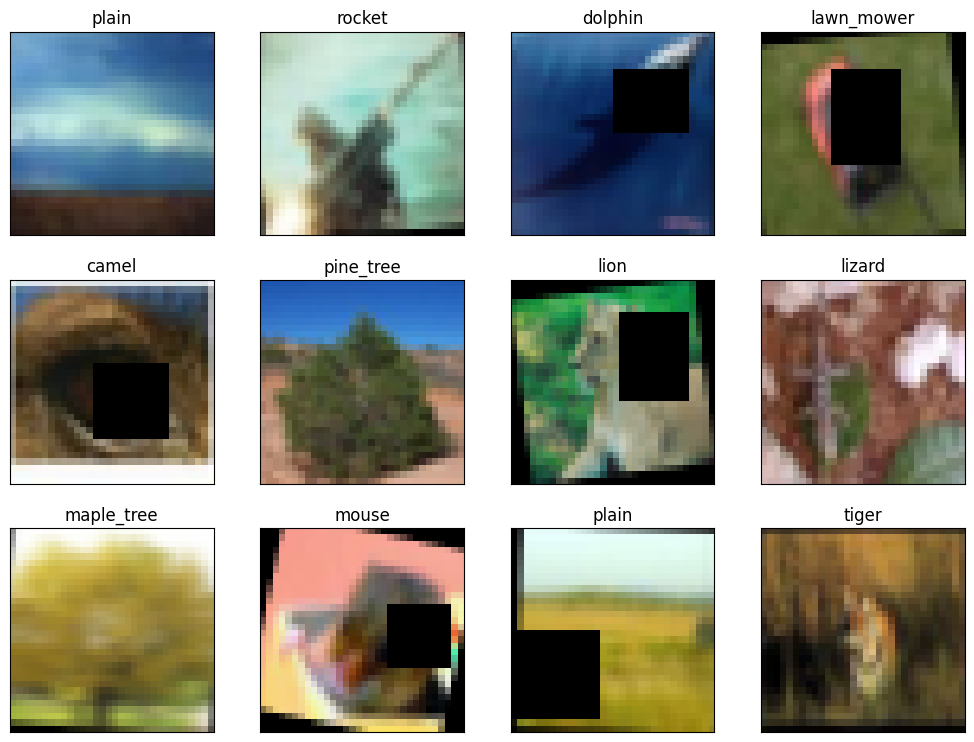

In [10]:
dataset_visualizer(train_loader)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

dummy_data = torch.randn(5, 3, 32, 32).to(device)
dummy_output = model(dummy_data)
print("Output shape:", dummy_output.shape)  # should be [5, 100]
summary(model, input_size=(3, 32, 32), device=str(device))

Output shape: torch.Size([5, 100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
    

/tmp/ipython-input-282305468.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.35E-03


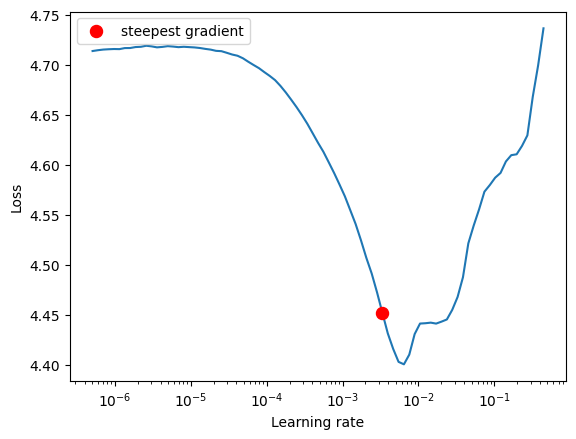

In [9]:
from torch_lr_finder import LRFinder

amp_config = {
    'device_type': 'cuda',
    'dtype': torch.float16,
}
grad_scaler = torch.cuda.amp.GradScaler()

model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

lr_finder = LRFinder(
    model, optimizer, criterion, device=device,
    amp_backend='torch', amp_config=amp_config, grad_scaler=grad_scaler
)
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

del(model)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.51E-03


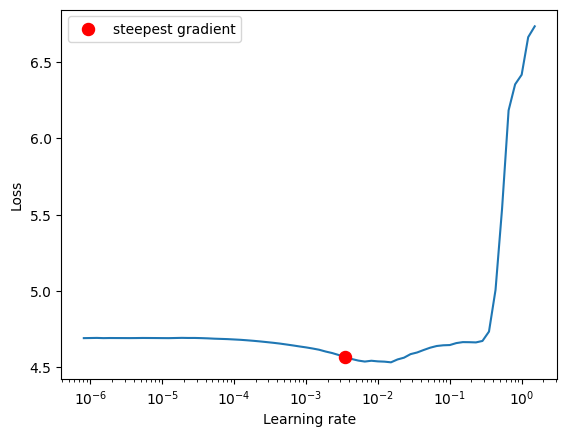

In [ ]:
# from torch_lr_finder import LRFinder

# model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state
#4e-3

In [13]:
# Learning rate chosen
lr_from_lr_finder = 4e-3
logger.info(f"Learning rate for one cycle LR = {lr_from_lr_finder}")

2025-10-17 01:42:22,898 - INFO - Learning rate for one cycle LR = 0.004


In [14]:
# ============================================================
# 1️⃣ Checkpoint utilities
# ============================================================

def save_checkpoint(model, optimizer, scheduler, epoch, best_loss, path):
    state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'best_loss': best_loss
    }
    torch.save(state, path)
    logger.info(f"✅ Checkpoint saved at epoch {epoch+1} to {path}")


def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    logger.info(f"✅ Resumed from checkpoint: epoch {start_epoch}, best loss {best_loss:.4f}")
    return start_epoch, best_loss

In [15]:
# ============================================================
# 2️⃣ Training Loop (OneCycleLR integrated)
# ============================================================
criterion = nn.CrossEntropyLoss()
train_loss_data = []
train_accuracy = []
test_loss_data = []
test_accuracy = []
learning_rate_over_steps = []

best_loss = float('inf')   # initialize with infinity

scaler = GradScaler()

def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ✅ Enable autocast for forward + loss
        with autocast():
            output = model(data)
            loss = criterion(output, target)

        # ✅ Backward using gradient scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()  # OneCycleLR updates per batch
        learning_rate_over_steps.append(optimizer.param_groups[0]['lr'])

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        pbar.set_description(desc=f'loss={loss.item():.4f} batch_id={batch_idx}')

    # Epoch-level stats
    avg_loss = running_loss / len(train_loader)
    acc = 100. * correct / total

    train_loss_data.append(avg_loss)
    train_accuracy.append(acc)

    print(f'\nTrain set (epoch {epoch}): Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({acc:.2f}%)\n')

# ============================================================
# 3️⃣ Testing Loop
# ============================================================

def test(model, device, test_loader, epoch):
    global best_loss  # to update across epochs
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_data.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(acc)

    print(f'Test set (epoch {epoch}): Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')

    # ✅ Save best model by lowest test loss
    if test_loss < best_loss:
        best_loss = test_loss
        save_dir = "/content/drive/MyDrive/Imagenet" if 'google.colab' in sys.modules else "."
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pt"))
        print(f"✅ Saved new best model at epoch {epoch} with loss {best_loss:.4f}")

    return test_loss


/tmp/ipython-input-722241764.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [16]:
# ============================================================
# 3️⃣ Model, optimizer, scheduler setup
# ============================================================

# Example: customize your ResNet to use partial depthwise convs
model = ResNet(layers=[2, 2, 3, 2], num_classes=100,
               use_depthwise=(False, False, True, True)).to(device)

if torch.__version__ >= "2.0.0":
    try:
        # compile BEFORE optimizer creation (recommended)
        model = torch.compile(model, backend="inductor", mode="max-autotune")
        print("✅ Model compiled successfully with torch.compile()!")
    except Exception as e:
        print(f"⚠️ torch.compile failed, continuing without it: {e}")
else:
    print("⚠️ torch.compile() not available in this PyTorch version.")

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# You already ran LR Finder earlier and got:
max_lr = lr_from_lr_finder   # Use from LR Finder output
total_epochs = 10 # Full plan (even if train 20+20)
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=total_epochs,
    pct_start=0.3,
    anneal_strategy="cos",
    div_factor=25.0,
    final_div_factor=1e4,
)

# ============================================================
# 4️⃣ Resume if checkpoint exists
# ============================================================

start_epoch = 0
save_dir = "/content/drive/MyDrive/Imagenet" if 'google.colab' in sys.modules else "."
os.makedirs(save_dir, exist_ok=True)
save_dir_file_name = os.path.join(save_dir, "checkpoint.pt")
if os.path.exists(save_dir_file_name):
    logger.info("Found checkpoint, loading checkpoint ...")
    start_epoch, best_loss = load_checkpoint(model, optimizer, scheduler, save_dir_file_name, device)
else:
    best_loss = float("inf")

# ============================================================
# 5️⃣ Main training loop
# ============================================================
start_time = time.time()
for epoch in range(start_epoch, total_epochs):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test_loss = test(model, device, test_loader, epoch)
    save_checkpoint(model, optimizer, scheduler, epoch, best_loss, save_dir_file_name)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

✅ Model compiled successfully with torch.compile()!


  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipython-input-722241764.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
W1017 01:42:57.041000 335 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(3072x100, 3072x512, 512x100)
strides: [0, 1], [512, 1], [1, 512]
dtypes: torch.float16, torch.float16, torch.float16
  addmm 0.1024 ms 100.0% 
  bias_addmm 0.1351 ms 75.8% 
SingleProcess AUTOTUNE benchmarking takes 0.0497 seconds and 0.0004 seconds precompiling for 2 choices
loss=4.7329 batch_id=0:   6%|▌         | 1/17 [02:57<47:15, 177.22s/it]/tmp/ipython-input-722241764.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss=4.6940 batch_id=1:  12%|█▏        | 2/17 [03:00<18:41, 74.76s/it] /tmp/ipython-input-722241764.py:28: FutureWarning: `torch.cuda.am


Train set (epoch 0): Average loss: 4.4643, Accuracy: 1617/50000 (3.23%)



AUTOTUNE addmm(3072x100, 3072x512, 512x100)
strides: [0, 1], [512, 1], [1, 512]
dtypes: torch.float32, torch.float32, torch.float32
  bias_addmm 0.2072 ms 100.0% 
  addmm 0.2173 ms 95.3% 
SingleProcess AUTOTUNE benchmarking takes 0.0683 seconds and 0.0002 seconds precompiling for 2 choices
2025-10-17 01:48:56,769 - INFO - ✅ Checkpoint saved at epoch 1 to /content/drive/MyDrive/Imagenet/checkpoint.pt


Test set (epoch 0): Average loss: 4.5642, Accuracy: 170/10000 (1.70%)

✅ Saved new best model at epoch 0 with loss 4.5642


  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipython-input-722241764.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss=4.1286 batch_id=1:  12%|█▏        | 2/17 [00:05<00:41,  2.79s/it]/tmp/ipython-input-722241764.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss=3.6577 batch_id=16: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]



Train set (epoch 1): Average loss: 3.8988, Accuracy: 4974/50000 (9.95%)



2025-10-17 01:49:40,072 - INFO - ✅ Checkpoint saved at epoch 2 to /content/drive/MyDrive/Imagenet/checkpoint.pt


Test set (epoch 1): Average loss: 4.3858, Accuracy: 331/10000 (3.31%)

✅ Saved new best model at epoch 1 with loss 4.3858


  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipython-input-722241764.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
loss=3.4184 batch_id=16: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]



Train set (epoch 2): Average loss: 3.5592, Accuracy: 7497/50000 (14.99%)

Test set (epoch 2): Average loss: 3.8327, Accuracy: 1216/10000 (12.16%)

✅ Saved new best model at epoch 2 with loss 3.8327


2025-10-17 01:50:22,194 - INFO - ✅ Checkpoint saved at epoch 3 to /content/drive/MyDrive/Imagenet/checkpoint.pt
loss=3.1129 batch_id=16: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]



Train set (epoch 3): Average loss: 3.1558, Accuracy: 11172/50000 (22.34%)

Test set (epoch 3): Average loss: 3.6284, Accuracy: 1604/10000 (16.04%)

✅ Saved new best model at epoch 3 with loss 3.6284


2025-10-17 01:51:04,140 - INFO - ✅ Checkpoint saved at epoch 4 to /content/drive/MyDrive/Imagenet/checkpoint.pt
loss=2.6888 batch_id=16: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]



Train set (epoch 4): Average loss: 2.8216, Accuracy: 14198/50000 (28.40%)



2025-10-17 01:51:46,486 - INFO - ✅ Checkpoint saved at epoch 5 to /content/drive/MyDrive/Imagenet/checkpoint.pt


Test set (epoch 4): Average loss: 3.0441, Accuracy: 2617/10000 (26.17%)

✅ Saved new best model at epoch 4 with loss 3.0441


loss=2.3901 batch_id=16: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it]



Train set (epoch 5): Average loss: 2.5295, Accuracy: 17243/50000 (34.49%)



2025-10-17 01:52:27,257 - INFO - ✅ Checkpoint saved at epoch 6 to /content/drive/MyDrive/Imagenet/checkpoint.pt


Test set (epoch 5): Average loss: 2.5365, Accuracy: 3378/10000 (33.78%)

✅ Saved new best model at epoch 5 with loss 2.5365


loss=2.2085 batch_id=16: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]



Train set (epoch 6): Average loss: 2.2751, Accuracy: 19980/50000 (39.96%)



2025-10-17 01:53:08,903 - INFO - ✅ Checkpoint saved at epoch 7 to /content/drive/MyDrive/Imagenet/checkpoint.pt


Test set (epoch 6): Average loss: 2.4277, Accuracy: 3803/10000 (38.03%)

✅ Saved new best model at epoch 6 with loss 2.4277


loss=1.9349 batch_id=16: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]



Train set (epoch 7): Average loss: 2.0740, Accuracy: 22235/50000 (44.47%)

Test set (epoch 7): Average loss: 2.0973, Accuracy: 4463/10000 (44.63%)

✅ Saved new best model at epoch 7 with loss 2.0973


2025-10-17 01:53:50,344 - INFO - ✅ Checkpoint saved at epoch 8 to /content/drive/MyDrive/Imagenet/checkpoint.pt
loss=2.0224 batch_id=16: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]



Train set (epoch 8): Average loss: 1.9450, Accuracy: 24022/50000 (48.04%)



2025-10-17 01:54:31,966 - INFO - ✅ Checkpoint saved at epoch 9 to /content/drive/MyDrive/Imagenet/checkpoint.pt


Test set (epoch 8): Average loss: 1.9857, Accuracy: 4668/10000 (46.68%)

✅ Saved new best model at epoch 8 with loss 1.9857


loss=1.8642 batch_id=16: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]



Train set (epoch 9): Average loss: 1.8752, Accuracy: 24839/50000 (49.68%)



2025-10-17 01:55:13,390 - INFO - ✅ Checkpoint saved at epoch 10 to /content/drive/MyDrive/Imagenet/checkpoint.pt


Test set (epoch 9): Average loss: 1.9369, Accuracy: 4771/10000 (47.71%)

✅ Saved new best model at epoch 9 with loss 1.9369
Elapsed time: 747.3501007556915 seconds


In [ ]:
# To disconnect and exit!
# from IPython.display import Javascript, display

# display(Javascript('google.colab.kernel.disconnect();'))


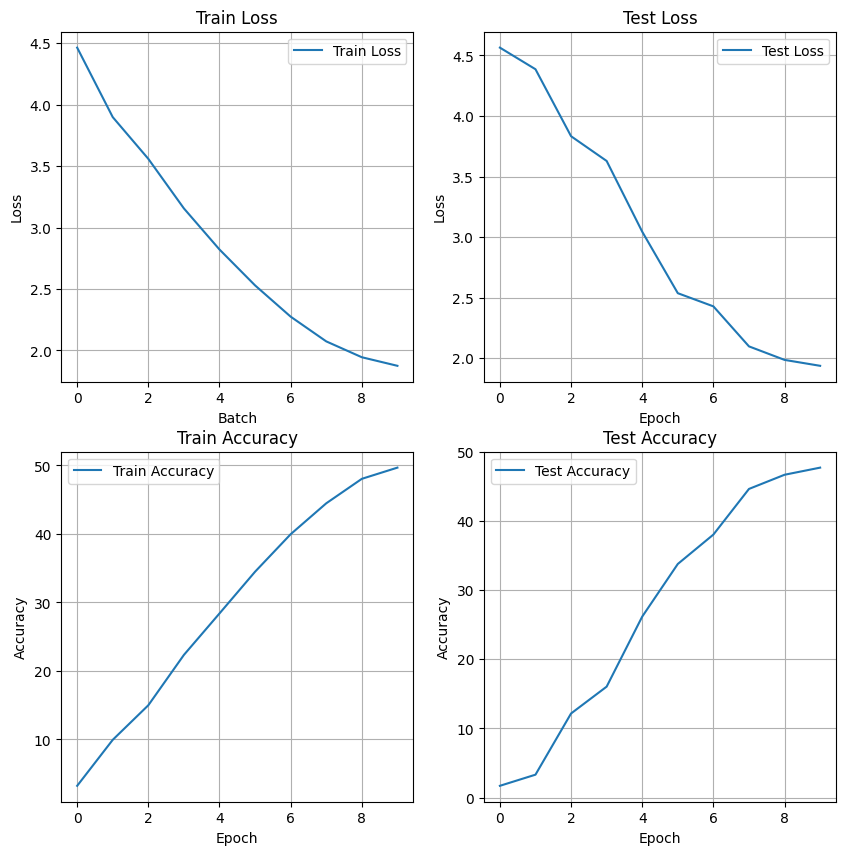

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(train_loss_data, label='Train Loss')
axs[0,0].set_xlabel('Batch')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('Train Loss')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(test_loss_data, label='Test Loss')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Test Loss')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(train_accuracy, label='Train Accuracy')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('Train Accuracy')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(test_accuracy, label='Test Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Test Accuracy')
axs[1,1].grid(True)
axs[1,1].legend()

plt.show()

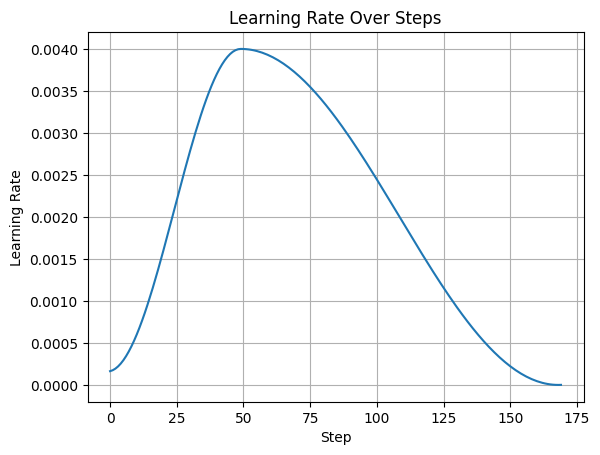

In [19]:
plt.plot(learning_rate_over_steps)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Steps')
plt.grid(True)
plt.show()